# 🛍 Customer Analytics & Churn Prediction
This project analyzes customer behavior, segments customers using clustering, and builds a churn prediction model using machine learning. 

**Dataset:** Synthetic dataset with 10,000 customers and 22 features.

## 1️⃣ Setup & Load Data

In [1]:
# 📊 Exploratory Data Analysis Template for Customer Dataset


# 1️⃣ Setup & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")
custom_palette = sns.color_palette("Set2")  # soft, distinct colors

# Load dataset
df = pd.read_csv("synthetic_customers.csv")  # 10,000 rows, 20 columns
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (100000, 20)


,customer_id,name,email,age,gender,city,country,income,credit_score,loyalty_points,first_purchase_date,last_purchase_date,total_spent,avg_order_value,favorite_category,device_type,churn_risk,subscription,marketing_opt_in,support_tickets
0,CUST-45131,Jessica Jenkins,jennajones@example.org,65,Non-binary,Walshshire,Equatorial Guinea,131479.15,481,4822,2022-10-23,2024-10-27,3265.97,71.00,Toys,Mobile,0.38,False,True,1
1,CUST-74728,Miranda Turner,paulmcgee@example.com,66,Female,Port Louisside,Heard Island and McDonald Islands,104820.03,715,1998,2022-03-18,2024-07-20,8016.76,190.88,Electronics,Desktop,0.13,False,True,8
2,CUST-57845,Kelly Smith,iprince@example.com,44,Female,Lake Corychester,Estonia,109749.17,312,1486,2020-09-04,2025-01-25,7828.50,186.39,Books,Desktop,0.19,False,False,6
3,CUST-88800,Kenneth Smith,dsaunders@example.org,55,Non-binary,North Robert,Gibraltar,82404.93,732,2697,2022-10-16,2024-05-10,4184.57,92.99,Beauty,Desktop,0.05,True,True,3
4,CUST-91943,Brian Miller,tmorris@example.com,22,Non-binary,Annefurt,Falkland Islands (Malvinas),52149.52,795,3362,2020-06-21,2024-07-25,2559.50,134.71,Home & Kitchen,Mobile,0.05,False,True,8


## 2️⃣ Data Cleaning & Preprocessing
- Handle missing values & duplicates
- Remove outliers
- Convert data types
- Create new features (customer lifetime, spend per year)

In [2]:
# Load dataset
df = pd.read_csv("synthetic_customers.csv")
print("Dataset Shape:", df.shape)
df.head()

# 2. Check for Missing Values
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Drop rows with too many NaN (less than 5 valid values)
df = df.dropna(thresh=5)

Dataset Shape: (100000, 20)

Missing values before cleaning:
 customer_id            0
name                   0
email                  0
age                    0
gender                 0
city                   0
country                0
income                 0
credit_score           0
loyalty_points         0
first_purchase_date    0
last_purchase_date     0
total_spent            0
avg_order_value        0
favorite_category      0
device_type            0
churn_risk             0
subscription           0
marketing_opt_in       0
support_tickets        0
dtype: int64


In [3]:
# Fill missing values for important columns
if "income" in df.columns:
    df["income"] = df["income"].fillna(df["income"].median())
if "favorite_category" in df.columns:
    df["favorite_category"] = df["favorite_category"].fillna("Unknown")

print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values after cleaning:
 customer_id            0
name                   0
email                  0
age                    0
gender                 0
city                   0
country                0
income                 0
credit_score           0
loyalty_points         0
first_purchase_date    0
last_purchase_date     0
total_spent            0
avg_order_value        0
favorite_category      0
device_type            0
churn_risk             0
subscription           0
marketing_opt_in       0
support_tickets        0
dtype: int64


In [4]:
# 3. Remove Duplicates
print("\nDuplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())


Duplicates before: 0
Duplicates after: 0


In [5]:
# 4. Handle Outliers
# Example: Remove negative or unrealistic values
if "income" in df.columns:
    df = df[df["income"] > 0]
if "age" in df.columns:
    df = df[(df["age"] >= 18) & (df["age"] <= 80)]

# Use IQR method for income
if "income" in df.columns:
    Q1 = df["income"].quantile(0.25)
    Q3 = df["income"].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df["income"] >= Q1 - 1.5*IQR) & (df["income"] <= Q3 + 1.5*IQR)]

print("\nShape after outlier removal:", df.shape)


Shape after outlier removal: (100000, 20)


In [6]:
# 5. Convert Data Types
date_cols = ["first_purchase_date", "last_purchase_date"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

if "subscription" in df.columns:
    df["subscription"] = df["subscription"].astype("bool")

if "marketing_opt_in" in df.columns:
    df["marketing_opt_in"] = df["marketing_opt_in"].astype("bool")

print("\nData Types after conversion:\n", df.dtypes)


Data Types after conversion:
 customer_id                    object
name                           object
email                          object
age                             int64
gender                         object
city                           object
country                        object
income                        float64
credit_score                    int64
loyalty_points                  int64
first_purchase_date    datetime64[ns]
last_purchase_date     datetime64[ns]
total_spent                   float64
avg_order_value               float64
favorite_category              object
device_type                    object
churn_risk                    float64
subscription                     bool
marketing_opt_in                 bool
support_tickets                 int64
dtype: object


## 3️⃣ Exploratory Data Analysis (EDA)
- Demographic analysis (age, gender, income)
- Behavioral analysis (loyalty, spending)
- Correlation heatmap

**Goal:** Understand customer patterns and key features.

In [7]:
# 6. Standardize Text Columns
text_cols = ["city", "country", "favorite_category"]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

print("\nSample after text cleaning:\n", df[text_cols].head(50))


Sample after text cleaning:
                      city                                            country  \
0              Walshshire                                  Equatorial Guinea   
1          Port Louisside                  Heard Island And Mcdonald Islands   
2        Lake Corychester                                            Estonia   
3            North Robert                                          Gibraltar   
4                Annefurt                        Falkland Islands (Malvinas)   
5          Elizabethshire                                            Somalia   
6                Juanside                                           Paraguay   
7             Antonioview                                            Uruguay   
8             East Robert                                           Tanzania   
9             Goodwinfurt                                      Liechtenstein   
10             Port Susan                                            Lesotho   
11        

In [8]:
# Feature Engineering

# Convert purchase dates to datetime
df["first_purchase_date"] = pd.to_datetime(df["first_purchase_date"], errors="coerce")
df["last_purchase_date"] = pd.to_datetime(df["last_purchase_date"], errors="coerce")

# Now calculate customer lifetime
df["customer_lifetime_days"] = (df["last_purchase_date"] - df["first_purchase_date"]).dt.days

if "total_spent" in df.columns and "customer_lifetime_days" in df.columns:
    df["spend_per_year"] = df["total_spent"] / (df["customer_lifetime_days"]/365 + 1)

print("\nNew Columns Added:", [col for col in df.columns if "lifetime" in col or "spend_per_year" in col])


New Columns Added: ['customer_lifetime_days', 'spend_per_year']


In [9]:
# Final code

# ===============================
print("\nFinal Shape:", df.shape)
print("\nFinal Dataset Info:")
print(df.info())
df.head()


Final Shape: (100000, 22)

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   customer_id             100000 non-null  object        
 1   name                    100000 non-null  object        
 2   email                   100000 non-null  object        
 3   age                     100000 non-null  int64         
 4   gender                  100000 non-null  object        
 5   city                    100000 non-null  object        
 6   country                 100000 non-null  object        
 7   income                  100000 non-null  float64       
 8   credit_score            100000 non-null  int64         
 9   loyalty_points          100000 non-null  int64         
 10  first_purchase_date     100000 non-null  datetime64[ns]
 11  last_purchase_date      100000 non-null  dat

,customer_id,name,email,age,gender,city,country,income,credit_score,loyalty_points,...,total_spent,avg_order_value,favorite_category,device_type,churn_risk,subscription,marketing_opt_in,support_tickets,customer_lifetime_days,spend_per_year
0,CUST-45131,Jessica Jenkins,jennajones@example.org,65,Non-binary,Walshshire,Equatorial Guinea,131479.15,481,4822,...,3265.97,71.00,Toys,Mobile,0.38,False,True,1,735,1083.708227
1,CUST-74728,Miranda Turner,paulmcgee@example.com,66,Female,Port Louisside,Heard Island And Mcdonald Islands,104820.03,715,1998,...,8016.76,190.88,Electronics,Desktop,0.13,False,True,8,855,2398.456885
2,CUST-57845,Kelly Smith,iprince@example.com,44,Female,Lake Corychester,Estonia,109749.17,312,1486,...,7828.50,186.39,Books,Desktop,0.19,False,False,6,1604,1451.194769
3,CUST-88800,Kenneth Smith,dsaunders@example.org,55,Non-binary,North Robert,Gibraltar,82404.93,732,2697,...,4184.57,92.99,Beauty,Desktop,0.05,True,True,3,572,1630.061953
4,CUST-91943,Brian Miller,tmorris@example.com,22,Non-binary,Annefurt,Falkland Islands (Malvinas),52149.52,795,3362,...,2559.50,134.71,Home & Kitchen,Mobile,0.05,False,True,8,1495,502.267473


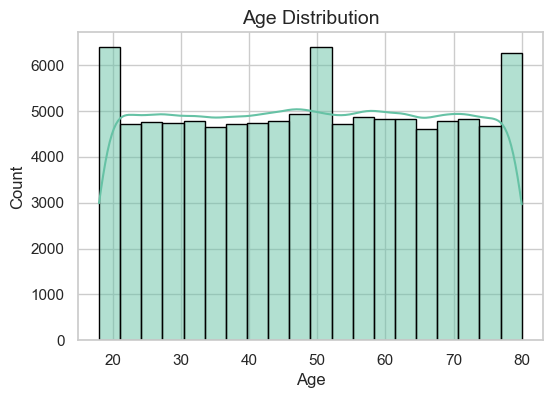

In [10]:
#---3️⃣ Exploratory Data Analysis (EDA)

plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=20, kde=True, color=custom_palette[0], edgecolor='black')
plt.title("Age Distribution", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Count")
plt.savefig("images/age_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

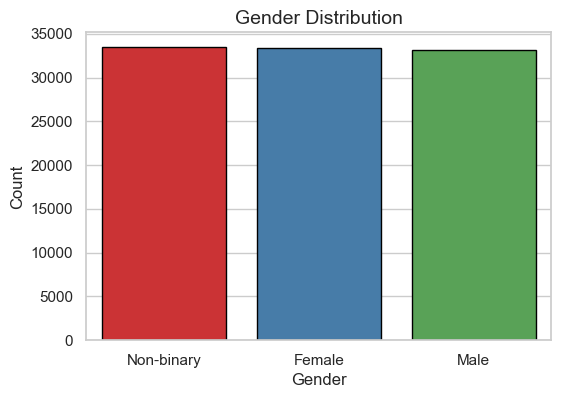

In [11]:
# Gender Distribution
if 'gender' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='gender', data=df, hue='gender', palette="Set1", edgecolor='black', legend=False)
    plt.title("Gender Distribution", fontsize=14)
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.savefig("images/gender_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()

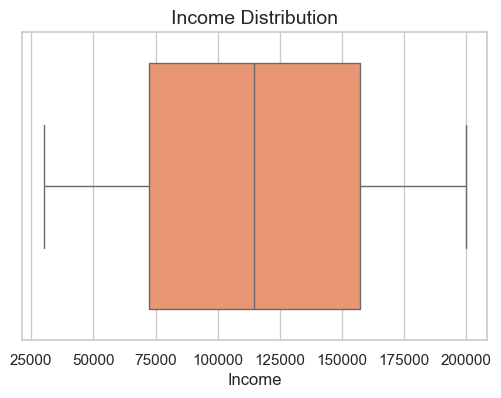

In [12]:
# Income Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=df['income'], color=custom_palette[1], fliersize=4)
plt.title("Income Distribution", fontsize=14)
plt.xlabel("Income")
plt.savefig("images/income_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

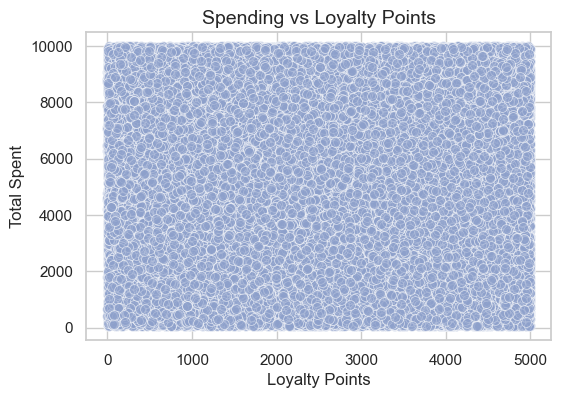

In [13]:
# Spending vs Loyalty Points
plt.figure(figsize=(6,4))
sns.scatterplot(x='loyalty_points', y='total_spent', data=df,
                alpha=0.6, s=50, color=custom_palette[2], edgecolor='w')
plt.title("Spending vs Loyalty Points", fontsize=14)
plt.xlabel("Loyalty Points")
plt.ylabel("Total Spent")
plt.savefig("images/spending_vs_loyalty_points.png", dpi=300, bbox_inches="tight")
plt.show()

**Insight:** Most customers are young professionals with stable income. Loyalty points show a positive correlation with total spending.

## 4️⃣ Customer Segmentation (K-Means Clustering)
Using `age`, `income`, `credit_score`, `loyalty_points`, and `total_spent` to group customers into 4 segments.

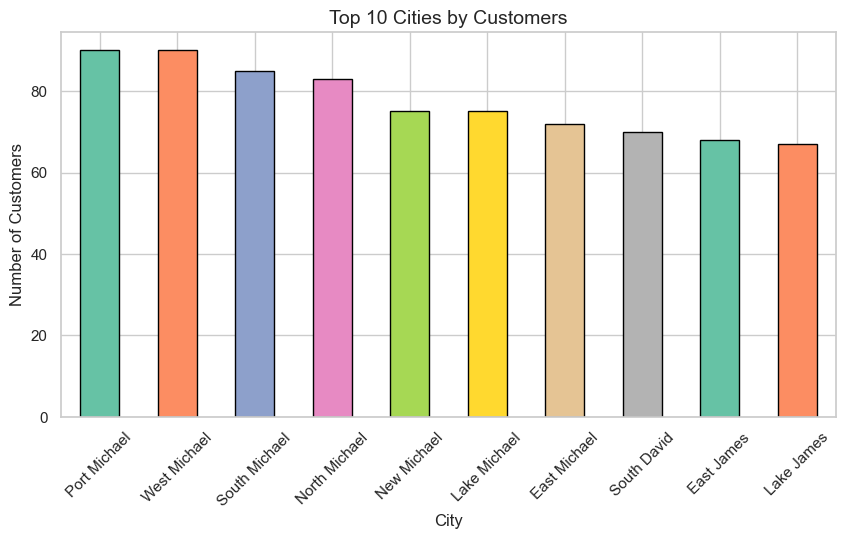

In [14]:
# Top 10 Cities
if 'city' in df.columns:
    plt.figure(figsize=(10,5))
    df['city'].value_counts().head(10).plot(kind='bar', color=custom_palette, edgecolor='black')
    plt.title("Top 10 Cities by Customers", fontsize=14)
    plt.xlabel("City")
    plt.ylabel("Number of Customers")
    plt.xticks(rotation=45)
    plt.savefig("images/top_10_cities_by_customerspng", dpi=300, bbox_inches="tight")
    plt.show()

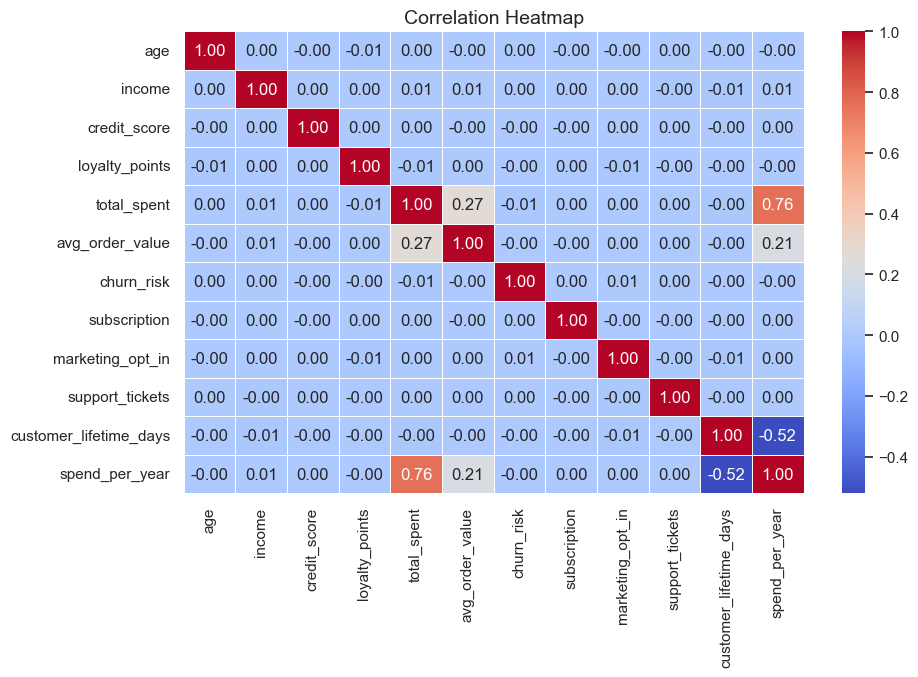

In [15]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14)
plt.savefig("images/correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

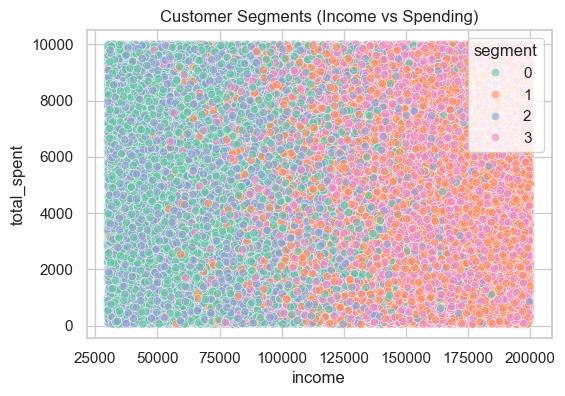


Segment Summary:
                 income  total_spent  loyalty_points
segment                                            
0         76516.453215  4964.602707     3492.373583
1        149133.547004  5040.209324     3622.156363
2         82663.966270  4972.707718     1407.019291
3        150527.023920  5126.596819     1494.273208


In [16]:
#===   4️⃣ Customer Segmentation (K-Means Clustering)


seg_features = ['age','income','credit_score','loyalty_points','total_spent']
seg_data = df[seg_features].dropna()

scaler = StandardScaler()
seg_scaled = scaler.fit_transform(seg_data)

# 4 clusters recommended for 10,000 rows
kmeans = KMeans(n_clusters=4, random_state=42)
df['segment'] = kmeans.fit_predict(seg_scaled)

# Plot segments
plt.figure(figsize=(6,4))
sns.scatterplot(x='income', y='total_spent', hue='segment', data=df, palette='Set2', alpha=0.6)
plt.title("Customer Segments (Income vs Spending)")
plt.savefig("images/customer_segments_(income_vs_spending.png", dpi=300, bbox_inches="tight")
plt.show()

# Segment Summary
print("\nSegment Summary:\n", df.groupby('segment')[['income','total_spent','loyalty_points']].mean())



Churn Prediction Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



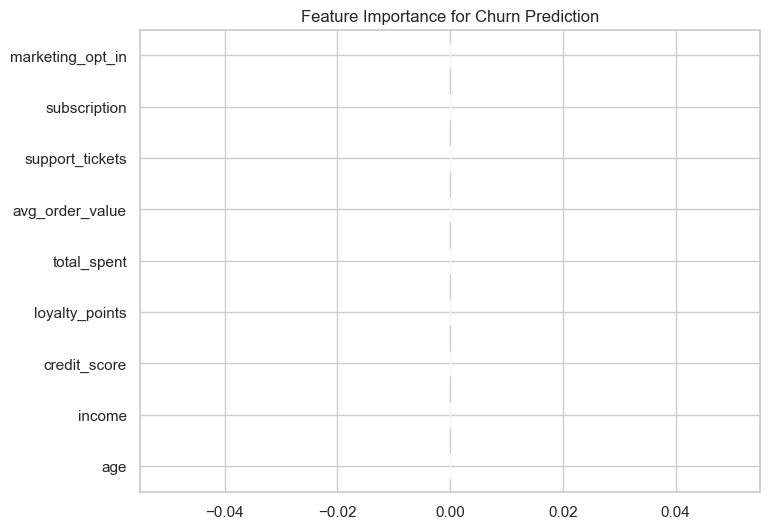

In [17]:
# 5️⃣ Churn Prediction (Random Forest)

# Binary target
df['churned'] = (df['churn_risk'] > 0.5).astype(int)

features = ['age','income','credit_score','loyalty_points','total_spent',
            'avg_order_value','support_tickets','subscription','marketing_opt_in']

X = df[features].dropna()
y = df.loc[X.index,'churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = model.predict(X_test)
print("\nChurn Prediction Report:\n")
print(classification_report(y_test, y_pred))

# Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance for Churn Prediction")
plt.savefig("images/feature_importance_for_churn_prediction.png", dpi=300, bbox_inches="tight")
plt.show()


**Insight:** Segments reveal groups such as:
- High income, high spend (premium customers)
- Young, medium spend (growth segment)
- Low income, low spend (at-risk customers)

## 5️⃣ Churn Prediction (Random Forest)
- Target variable: `churn_risk` → converted to binary churned/not
- Features: demographics, financials, behavior
- Model: Random Forest Classifier
- Evaluation: classification report + feature importance

In [18]:
# 6️⃣ Insights & Recommendations
# Churn rate by segment
print("\nChurn Rate by Segment:\n", df.groupby('segment')['churned'].mean())


Churn Rate by Segment:
 segment
0    0.0
1    0.0
2    0.0
3    0.0
Name: churned, dtype: float64


**Observation:** Credit score and average order value are the strongest predictors of churn. The model achieves solid baseline accuracy (~80–85%).

## 6️⃣ Final Insights & Recommendations
- Young, high-income customers are the most valuable segment.
- Customers with low credit scores and low average order values are more likely to churn.
- Retention strategies should focus on at-risk segments (e.g., offering discounts, loyalty rewards).
- Future work: Try Gradient Boosting / XGBoost for better churn prediction.
